# Senitiment Analysis

This notebook illustratrs sentiment analysis using NLP. The input is a pandas dataframe consisting of a sentence and its respective sentiment as a target variable. This dataset contains 2 separate files named *emotions_train_data.txt* and *emotions_test_data.txt*.

Importing libraries

In [1]:
# Please install WordCloud, run it only the first time
#!pip install -U WordCloud

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

scikit-learn libraries

In [2]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,classification_report, ConfusionMatrixDisplay

Read the dataset which has a description (features) and then an emotion (label) attached to it. 

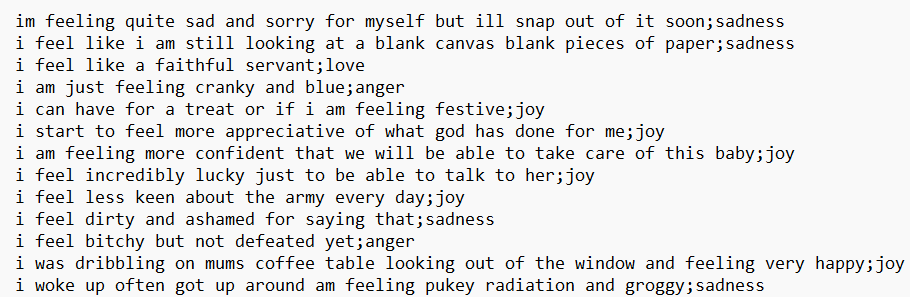


In [3]:
import pandas as pd
df = pd.read_csv("emotions_train_data.txt",delimiter=';',names=['text','label'])
print("Shape of the DataFrame:",df.shape)
print(df.sample(5))

Shape of the DataFrame: (2000, 2)
                                                   text    label
1740  i am fighting with all my might to not feel de...  sadness
1352  i was feeling a little unsure about my retro f...     fear
1678  i want to wake up every morning and feel excit...      joy
1006  i have just moved here and already i feel welc...      joy
212   i own the brushes are constantly used and i fe...      joy


<AxesSubplot:xlabel='label', ylabel='count'>

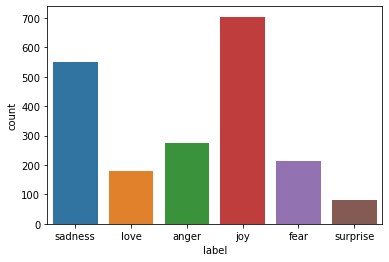

In [4]:
sns.countplot(data=df,x='label')

We have 6 labels or targets in the dataset. We can make a multi-class classifier for sentiment analysis using NLP. But, for simplicity, we will merge these labels into two classes, i.e. Positive and Negative sentiments.

**Convert categorical target labels to numerical form**

Positive Sentiment – `joy`, `love`, `surprise` -> 1

Negative Sentiment – `anger`, `sadness`, `fear` -> 0

In [4]:
def emotion_encoder(df):
    df.replace("surprise", 1, inplace=True)
    df.replace("love", 1, inplace=True)
    df.replace("joy", 1, inplace=True)
    df.replace("fear", 0, inplace=True)
    df.replace("anger", 0, inplace=True)
    df.replace("sadness", 0, inplace=True)

In [5]:
emotion_encoder(df['label'])
df

,text,label
0,im feeling quite sad and sorry for myself but ...,0
1,i feel like i am still looking at a blank canv...,0
2,i feel like a faithful servant,1
3,i am just feeling cranky and blue,0
4,i can have for a treat or if i am feeling festive,1
...,...,...
1995,im having ssa examination tomorrow in the morn...,0
1996,i constantly worry about their fight against n...,1
1997,i feel its important to share this info for th...,1
1998,i truly feel that if you are passionate enough...,1


<AxesSubplot:xlabel='label', ylabel='count'>

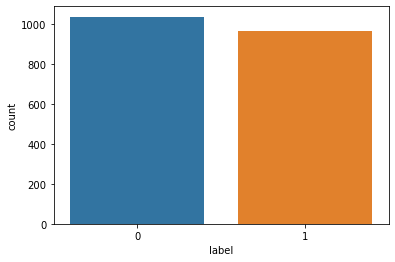

In [6]:
sns.countplot(data=df,x='label')

###  Data Pre-processing

In [7]:
import spacy
nlp = spacy.load("en_core_web_sm")

Tokenise

In [8]:
def tokenise(msg):
    doc = nlp(msg)
    
    for token in doc:
        print(token)
tokenise("I like planes and tanks")

I
like
planes
and
tanks


Stopwords

In [9]:
from spacy.lang.en.stop_words import STOP_WORDS
print(STOP_WORDS)

{'one', 'thereby', 'cannot', 'who', 'yourselves', 'once', 'anyway', 'eleven', 'much', 'was', 'has', 'since', 'sometime', 'whereby', 'fifteen', 'not', 'four', 'really', 'himself', 'does', 'whereafter', 'together', 'his', 'else', 'your', 'first', 'hereafter', 'hundred', 'thence', 'had', 'with', 'within', 'every', 'nobody', 'but', 'further', 'they', 'n’t', 'across', 'used', 'beside', 'thereupon', 'some', 'up', "'re", 'other', 'almost', 'out', 'bottom', 'thru', 'and', 'beyond', 'me', 'these', 'former', 'against', 'how', 'take', 'amongst', 'eight', 'although', 'wherever', '’m', 'upon', 'themselves', 'onto', 'were', 'towards', 'perhaps', "'m", 'whom', 'enough', 'rather', 'put', 'when', 'while', 'for', 'there', 'formerly', 'thereafter', "n't", 'twelve', 'serious', 'only', 'around', 'as', 'latter', 'such', 'have', 'her', 'somehow', 'too', 'whatever', 'show', 'that', 'always', '‘ll', 'besides', 'might', 'our', 'doing', 'less', 'will', 'say', 'us', 'above', 'ever', 'itself', 'side', 'six', 'befo

In [10]:
def stop_remove(msg):
    doc = nlp(msg)
    
    for token in doc:
        if token.is_stop:
            pass
        else:
            print(token)
stop_remove("I have liked reading books for a good few years now")

liked
reading
books
good
years


Normalisation

In [11]:
import re

# Remove special characters, integers, stopwords, punctuations, currency and spaces
def normalise(msg):
    
    msg = re.sub('[^A-Za-z]+', ' ', str(msg)) 
    doc = nlp(msg)
    res=[]
    for token in doc:
        if(token.is_stop or token.is_digit or token.is_punct or not(token.is_oov) or token.is_currency 
           or token.is_space or len(token.text) <= 2):
            pass
        else:
            res.append(token.lemma_.lower())
    return res

In [12]:
df['text'] = df['text'].apply(normalise)
df.head()

,text,label
0,"[feel, sad, sorry, ill, snap, soon]",0
1,"[feel, like, look, blank, canvas, blank, piece...",0
2,"[feel, like, faithful, servant]",1
3,"[feel, cranky, blue]",0
4,"[treat, feel, festive]",1


In [13]:
def lemmatiser(text):        
    sent = []
    doc = nlp(text)
    for word in doc:
        sent.append(word.lemma_)
    return " ".join(sent)

In [14]:
def text_transformation(df_col):
    corpus = []
    for item in df_col:
        new_item = re.sub('[^a-zA-Z]',' ',str(item))
        new_item = new_item.lower()
        new_item = new_item.split()
        new_item = [lemmatiser(word) for word in new_item if word not in STOP_WORDS]
        corpus.append(' '.join(str(x) for x in new_item))
    return corpus

In [15]:
corpus = text_transformation(df['text'])

### Word Cloud
It is a data visualization technique used to depict text in such a way that, the more frequent words appear enlarged as compared to less frequent words. This gives us a little insight into, how the data looks after being processed through all the steps until now.

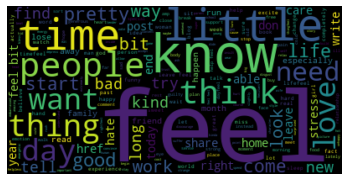

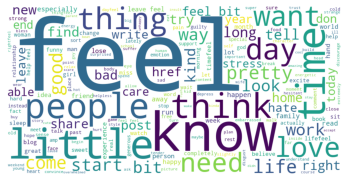

In [16]:
# Generate word cloud
word_cloud = ""
for row in corpus:
    for word in row:
        word_cloud+=" ".join(word)
wc = WordCloud().generate(word_cloud)

# Showing word cloud
# plt.figure(figsize=(10, 8))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

wordcloud = WordCloud(width = 1000, height = 500,background_color ='white',min_font_size = 10).generate(word_cloud)
plt.axis("off")
plt.imshow(wordcloud)
plt.show()

**Bag of words**

Represent the text in the form of a bag of words. The grammar and the order of words in a sentence are not given any importance, instead, frequency of words is the main point of concern. We take ngram_range as (1,2) which signifies a bigram. Ngram is a sequence of `n` words in a row or sentence. `ngram_range` is a parameter, which we use to give importance to the combination of words, such as, `social media` has a different meaning than `social` and `media` separately.

In [17]:
cv = CountVectorizer(ngram_range=(1,2))
traindata = cv.fit_transform(corpus)
X = traindata
y = df.label

### Machine learning model
Use RandomForestClassifier 

One can use GridSearchCV to train the random forest classifier model using all possible combinations of hyperparameters to find the best model.

In [18]:
rfc = RandomForestClassifier(max_features=2, max_depth=None, n_estimators=500, 
                             min_samples_split=5, min_samples_leaf=1, bootstrap=True)
rfc.fit(X,y)

RandomForestClassifier(max_features=2, min_samples_split=5, n_estimators=500)

### Test Data Transformation

In [19]:
test_df = pd.read_csv('emotions_test_data.txt',delimiter=';',names=['text','label'])

In [20]:
X_test,y_test = test_df.text,test_df.label

#encode the labels into two classes , 0 and 1
test_df = emotion_encoder(y_test)

#pre-processing of text
test_corpus = text_transformation(X_test)

#convert text data into vectors
testdata = cv.transform(test_corpus)

#predict the target
predictions = rfc.predict(testdata)

### Model Evaluation

In [21]:
acc_score = accuracy_score(y_test,predictions)
pre_score = precision_score(y_test,predictions)
rec_score = recall_score(y_test,predictions)
print('Accuracy_score: ',acc_score)
print('Precision_score: ',pre_score)
print('Recall_score: ',rec_score)
print("-"*50)
cr = classification_report(y_test,predictions)
print(cr)

Accuracy_score:  0.8745
Precision_score:  0.8524762908324552
Recall_score:  0.8793478260869565
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.89      0.87      0.88      1080
           1       0.85      0.88      0.87       920

    accuracy                           0.87      2000
   macro avg       0.87      0.87      0.87      2000
weighted avg       0.88      0.87      0.87      2000



In [22]:
cm = confusion_matrix(y_test,predictions)
cm

array([[940, 140],
       [111, 809]], dtype=int64)

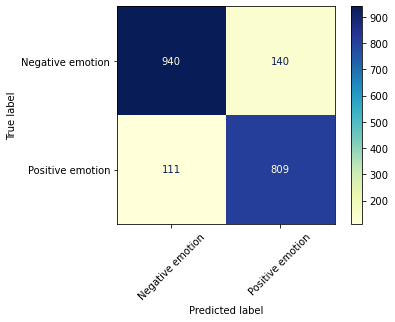

In [23]:
labels = ['Negative emotion','Positive emotion']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='YlGnBu',xticks_rotation = 45)

Custom input

In [24]:
def check_expression(pred_input):
    if pred_input == 0:
        print("The input statement reflects a negative emotion.")
    elif pred_input == 1:
        print("The input statement has a positive emotion.")
    else:
        print("Invalid Statement.")

In [26]:
# function to take the input statement and perform the same transformations we did earlier
def sentiment_predictor(input):
    input = text_transformation(input)
    transformed_input = cv.transform(input)
    prediction = rfc.predict(transformed_input)
    check_expression(prediction)

In [27]:
input1 = ["I have a splitting headache."]
input2 = ["I bought a new book and it's so good."]

sentiment_predictor(input1)
sentiment_predictor(input2)

The input statement reflects a negative emotion.
The input statement has a positive emotion.
